In [1]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns


from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

2024-12-11 13:04:31.950701: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 13:04:31.990195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 13:04:31.990226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 13:04:31.991093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 13:04:31.996929: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 13:04:31.999251: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# the following are needed to ensure that text in plt images opens as text box rather than glyphs in adobe
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams['ps.fonttype'] = 42   # Apply to PostScript as well


In [3]:
!pwd

/data/projects/zeba/MY_PROJECTS/240130_Xenium_ANCA_SLE_GBM/xenium-cgn/notebooks_zs/03b_CellComposition_scCODA


## AnnData Object with everything
Shared by Robin on 31 Oct Slack with me:
/data/projects/robin/segmentation/xenium_outs/adata_complete_reduced_withTransformedMC.h5ad
This is also the object that I have used for the Cellchat Analysis

In [4]:
adata = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/adata_complete_reduced_withTransformedMC.h5ad")
adata

AnnData object with n_obs × n_vars = 3218210 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'label', 'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no', 'glom_ID', 'polygon_flags', 'is_in_polygon', 'is_in_glom', 'is_in_periglom', 'Slide_num'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_l1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'

### Subset Cell within perigloms

In [5]:
adata=adata[adata.obs['is_in_periglom']==True]
adata

View of AnnData object with n_obs × n_vars = 428770 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'label', 'nichepca_domain', 'nichepca_domain_tuned', 'nichepca_glom_no', 'glom_ID', 'polygon_flags', 'is_in_polygon', 'is_in_glom', 'is_in_periglom', 'Slide_num'
    var: 'gene_ids', 'feature_types'
    uns: 'celltype_l1_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'

In [6]:
adata.obs["Patient_Sample_ID"]

cell_CR4f0dee9aa-1334        X8_SLE
cell_CR4f0dee9aa-1340        X8_SLE
cell_CR4f0dee9aa-1373        X8_SLE
cell_CR4f0dee9aa-1397        X8_SLE
cell_CR4f0dee9aa-1421        X8_SLE
                             ...   
cell_CR4113b3b6d-452577    X63_ANCA
cell_CR4113b3b6d-452743    X63_ANCA
cell_CR4113b3b6d-453127    X58_ANCA
cell_CR4113b3b6d-453235    X63_ANCA
cell_CR4113b3b6d-453890    X63_ANCA
Name: Patient_Sample_ID, Length: 428770, dtype: category
Categories (58, object): ['X1_Cntrl', 'X2_Cntrl', 'X3_ANCA', 'X4_ANCA', ..., 'X60_ANCA', 'X61_SLE', 'X62_SLE', 'X63_ANCA']

In [7]:
df_sample_celltypes = adata.obs[["Patient_Sample_ID","celltype_l1"]]
df_sample_celltypes

,Patient_Sample_ID,celltype_l1
cell_CR4f0dee9aa-1334,X8_SLE,PT
cell_CR4f0dee9aa-1340,X8_SLE,CNT
cell_CR4f0dee9aa-1373,X8_SLE,MAC
cell_CR4f0dee9aa-1397,X8_SLE,CNT
cell_CR4f0dee9aa-1421,X8_SLE,EC
...,...,...
cell_CR4113b3b6d-452577,X63_ANCA,FIB
cell_CR4113b3b6d-452743,X63_ANCA,EC
cell_CR4113b3b6d-453127,X58_ANCA,FIB
cell_CR4113b3b6d-453235,X63_ANCA,VSM/P


In [8]:
df_sampleXcelltypes = df_sample_celltypes.groupby(["Patient_Sample_ID","celltype_l1"]).size().reset_index(name='counts')
df_sampleXcelltypes

,Patient_Sample_ID,celltype_l1,counts
0,X1_Cntrl,podocyte,53
1,X1_Cntrl,PEC,771
2,X1_Cntrl,mesangial cell,95
3,X1_Cntrl,PapE,31
4,X1_Cntrl,VSM/P,944
...,...,...,...
1677,X63_ANCA,MAST,64
1678,X63_ANCA,cDC,184
1679,X63_ANCA,pDC,25
1680,X63_ANCA,cycMNP,556


In [9]:
df_sampleXcelltypes = df_sampleXcelltypes.pivot(index= "Patient_Sample_ID", columns="celltype_l1", values="counts").fillna(0)
df_sampleXcelltypes = df_sampleXcelltypes.astype(int)

In [10]:
df_sampleXcelltypes

celltype_l1,podocyte,PEC,mesangial cell,PapE,VSM/P,EC,PT,ATL,CNT,DCT,...,PL,N,MAC,MDC,Mono,MAST,cDC,pDC,cycMNP,cycNKC/T
Patient_Sample_ID,,,,,,,,,,,,,,,,,,,,,
X1_Cntrl,53,771,95,31,944,1417,3666,14,914,500,...,42,21,507,240,62,38,62,19,17,3
X2_Cntrl,48,82,29,13,74,240,575,7,72,114,...,5,7,77,32,13,13,5,2,8,1
X3_ANCA,35,122,54,20,133,445,980,7,201,98,...,125,43,370,353,123,18,45,13,52,8
X4_ANCA,27,80,20,20,122,303,567,6,112,37,...,59,25,212,245,57,55,26,12,13,2
X6_ANCA,33,72,14,7,86,242,743,3,83,30,...,4,19,157,20,11,8,7,0,4,2
X7_SLE,33,145,18,15,89,329,821,6,109,124,...,52,29,261,88,30,7,10,5,12,3
X8_SLE,2,2,1,1,3,10,12,1,9,11,...,3,1,6,0,4,1,0,0,0,0
X9_Cntrl,44,91,62,34,215,439,962,7,351,377,...,18,17,176,40,19,13,9,5,7,1
X10_Cntrl,140,418,123,38,533,1981,8368,35,1102,625,...,35,37,489,48,56,29,52,11,26,4


In [11]:
df_sampleXcelltypes["Patient_Sample_ID_col"]=df_sampleXcelltypes.index
df_sampleXcelltypes

celltype_l1,podocyte,PEC,mesangial cell,PapE,VSM/P,EC,PT,ATL,CNT,DCT,...,N,MAC,MDC,Mono,MAST,cDC,pDC,cycMNP,cycNKC/T,Patient_Sample_ID_col
Patient_Sample_ID,,,,,,,,,,,,,,,,,,,,,
X1_Cntrl,53,771,95,31,944,1417,3666,14,914,500,...,21,507,240,62,38,62,19,17,3,X1_Cntrl
X2_Cntrl,48,82,29,13,74,240,575,7,72,114,...,7,77,32,13,13,5,2,8,1,X2_Cntrl
X3_ANCA,35,122,54,20,133,445,980,7,201,98,...,43,370,353,123,18,45,13,52,8,X3_ANCA
X4_ANCA,27,80,20,20,122,303,567,6,112,37,...,25,212,245,57,55,26,12,13,2,X4_ANCA
X6_ANCA,33,72,14,7,86,242,743,3,83,30,...,19,157,20,11,8,7,0,4,2,X6_ANCA
X7_SLE,33,145,18,15,89,329,821,6,109,124,...,29,261,88,30,7,10,5,12,3,X7_SLE
X8_SLE,2,2,1,1,3,10,12,1,9,11,...,1,6,0,4,1,0,0,0,0,X8_SLE
X9_Cntrl,44,91,62,34,215,439,962,7,351,377,...,17,176,40,19,13,9,5,7,1,X9_Cntrl
X10_Cntrl,140,418,123,38,533,1981,8368,35,1102,625,...,37,489,48,56,29,52,11,26,4,X10_Cntrl


In [12]:
#df_sampleXcelltypes.rename(columns={"Transformed mesangial": "Fibro. mesangial"}, inplace=True)
#df_sampleXcelltypes.rename(columns={"mesangial cell": "mesang. cells"}, inplace=True)

In [13]:
# df_sampleXcelltypes["condition"]=df_sampleXcelltypes["Patient_Sample_ID_col"].str.split("_").str[1]

#con_order=['Cntrl', 'SLE', 'ANCA', 'GBM']
#df_sampleXcelltypes["condition"]=pd.Categorical(df_sampleXcelltypes["condition"], categories=con_order, ordered=True)

## Convert the df to a AnnData object

In [14]:
data_Xen = dat.from_pandas(df_sampleXcelltypes, covariate_columns=["Patient_Sample_ID_col"])

# Extract condition from mouse name and add it as an extra column to the covariates
#data_mouse.obs["Condition"] = data_mouse.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_Xen.X)
print(data_Xen.obs)
data_Xen

[[ 53 771  95 ...  19  17   3]
 [ 48  82  29 ...   2   8   1]
 [ 35 122  54 ...  13  52   8]
 ...
 [  6  35   2 ...   0   8   2]
 [ 32  60  53 ...   1  17   2]
 [134 328  61 ...  25 556  48]]
celltype_l1       Patient_Sample_ID_col
Patient_Sample_ID                      
X1_Cntrl                       X1_Cntrl
X2_Cntrl                       X2_Cntrl
X3_ANCA                         X3_ANCA
X4_ANCA                         X4_ANCA
X6_ANCA                         X6_ANCA
X7_SLE                           X7_SLE
X8_SLE                           X8_SLE
X9_Cntrl                       X9_Cntrl
X10_Cntrl                     X10_Cntrl
X12_ANCA                       X12_ANCA
X13_GBM                         X13_GBM
X14_ANCA                       X14_ANCA
X15_SLE                         X15_SLE
X16_SLE                         X16_SLE
X17_ANCA                       X17_ANCA
X18_ANCA                       X18_ANCA
X19_ANCA                       X19_ANCA
X20_ANCA                       X20_ANCA
X21_GBM 

AnnData object with n_obs × n_vars = 58 × 29
    obs: 'Patient_Sample_ID_col'

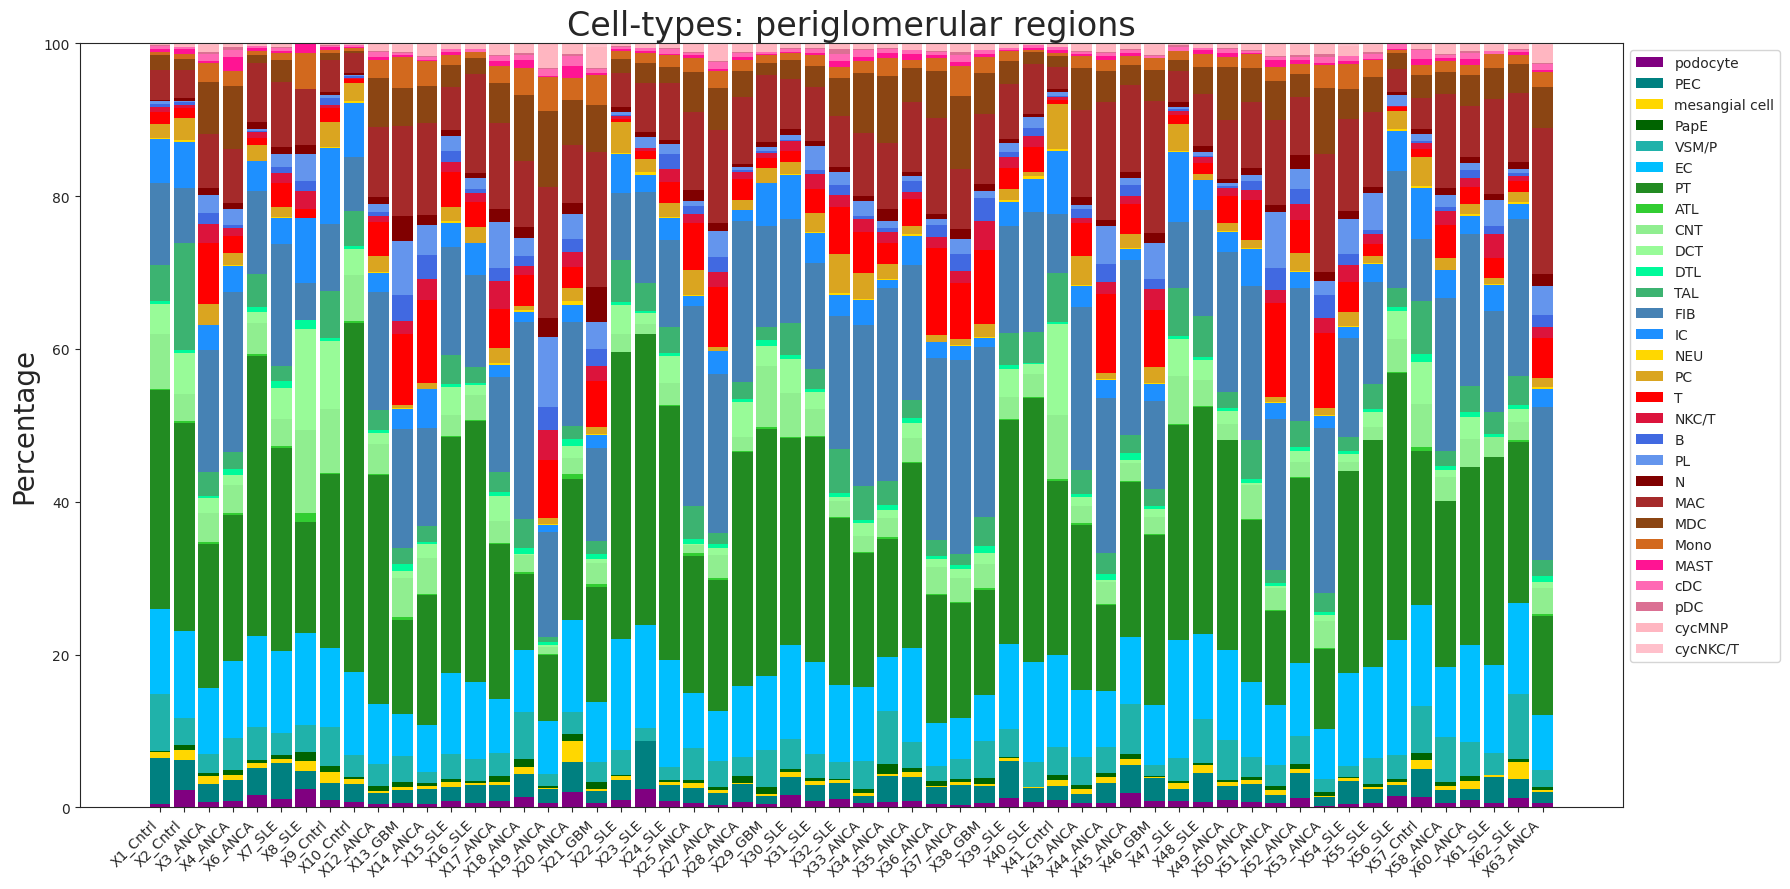

In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sccoda.util import data_visualization as viz

# Extract the colors from adata
colors = adata.uns["celltype_l1_colors"]

# Convert the list of colors to a Matplotlib colormap
colormap = ListedColormap(colors)

plt.rcParams['figure.figsize'] = [18, 9]
viz.stacked_barplot(data=data_Xen, feature_name="Patient_Sample_ID_col", cmap=colormap)

# Customize fonts and plot
title_fontsize = 24
label_fontsize = 20
tick_fontsize = 10
legend_fontsize = 18

plt.title('Cell-types: periglomerular regions', fontsize=title_fontsize)
#plt.xlabel("")  # Remove x-axis label
plt.ylabel('Percentage', fontsize=label_fontsize)
plt.xticks(rotation=45, fontsize=tick_fontsize, ha='right', va='top')
plt.yticks(fontsize=tick_fontsize)
#plt.legend(title='Condition', title_fontsize=legend_fontsize, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("Barplot_CellType_Percentages_periglom.png")
plt.savefig("Barplot_CellType_Percentages_periglom.pdf")
plt.show()

In [16]:
samples = df_sampleXcelltypes.index

# Sorting key to prioritize "Cntrl", "SLE", "ANCA", "GBM"
priority = {"Cntrl": 0, "SLE": 1, "ANCA": 2, "GBM": 3}

# Custom sorting function
sorted_samples = sorted(samples, key=lambda x: priority[x.split('_')[1]])

# Output the sorted list
print(sorted_samples)


['X1_Cntrl', 'X2_Cntrl', 'X9_Cntrl', 'X10_Cntrl', 'X41_Cntrl', 'X57_Cntrl', 'X7_SLE', 'X8_SLE', 'X15_SLE', 'X16_SLE', 'X22_SLE', 'X23_SLE', 'X24_SLE', 'X30_SLE', 'X31_SLE', 'X32_SLE', 'X39_SLE', 'X40_SLE', 'X47_SLE', 'X48_SLE', 'X54_SLE', 'X55_SLE', 'X56_SLE', 'X61_SLE', 'X62_SLE', 'X3_ANCA', 'X4_ANCA', 'X6_ANCA', 'X12_ANCA', 'X14_ANCA', 'X17_ANCA', 'X18_ANCA', 'X19_ANCA', 'X20_ANCA', 'X25_ANCA', 'X27_ANCA', 'X28_ANCA', 'X33_ANCA', 'X34_ANCA', 'X35_ANCA', 'X36_ANCA', 'X37_ANCA', 'X43_ANCA', 'X44_ANCA', 'X45_ANCA', 'X49_ANCA', 'X50_ANCA', 'X51_ANCA', 'X52_ANCA', 'X53_ANCA', 'X58_ANCA', 'X60_ANCA', 'X63_ANCA', 'X13_GBM', 'X21_GBM', 'X29_GBM', 'X38_GBM', 'X46_GBM']


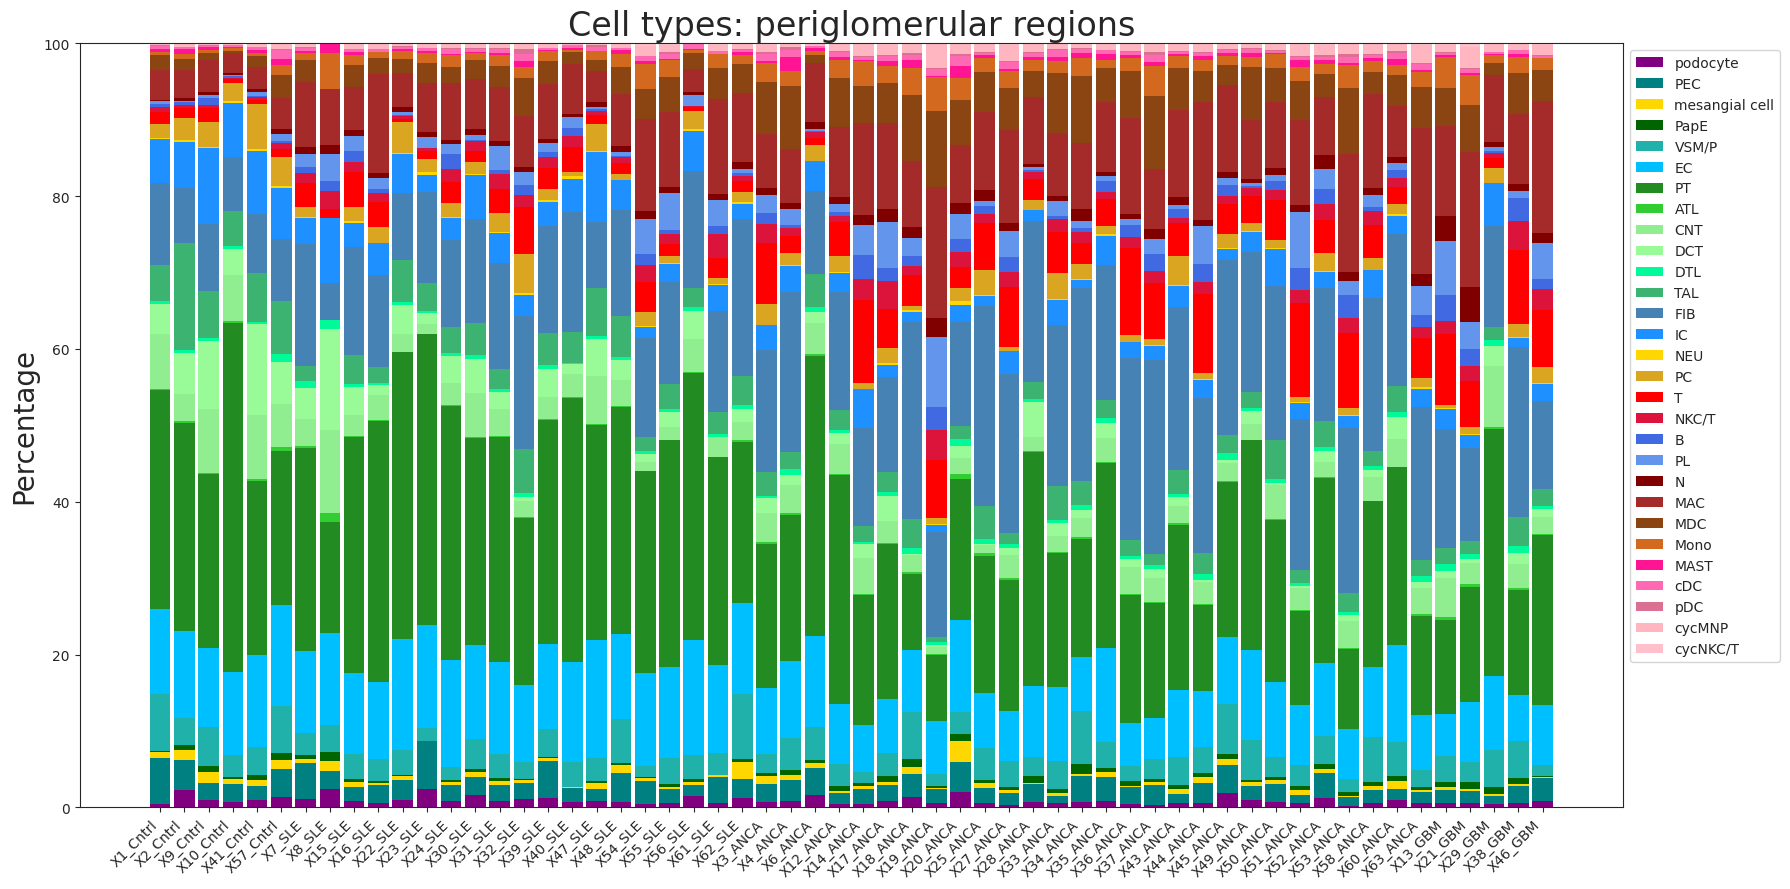

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sccoda.util import data_visualization as viz

# Extract the colors from adata
colors = adata.uns["celltype_l1_colors"]

# Convert the list of colors to a Matplotlib colormap
colormap = ListedColormap(colors)


plt.rcParams['figure.figsize'] = [18, 9]
viz.stacked_barplot(data=data_Xen, feature_name="Patient_Sample_ID_col", cmap=colormap, level_order = sorted_samples)

# Customize fonts and plot
title_fontsize = 24
label_fontsize = 20
tick_fontsize = 10
legend_fontsize = 18

plt.title('Cell types: periglomerular regions', fontsize=title_fontsize)
#plt.xlabel("")  # Remove x-axis label
plt.ylabel('Percentage', fontsize=label_fontsize)
plt.xticks(rotation=45, fontsize=tick_fontsize, ha='right', va='top')
plt.yticks(fontsize=tick_fontsize)
#plt.legend(title='Condition', title_fontsize=legend_fontsize, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("Barplot_CellType_Percentages_periglom_SORTED.png")
plt.savefig("Barplot_CellType_Percentages_periglom_SORTED.pdf")
plt.show()

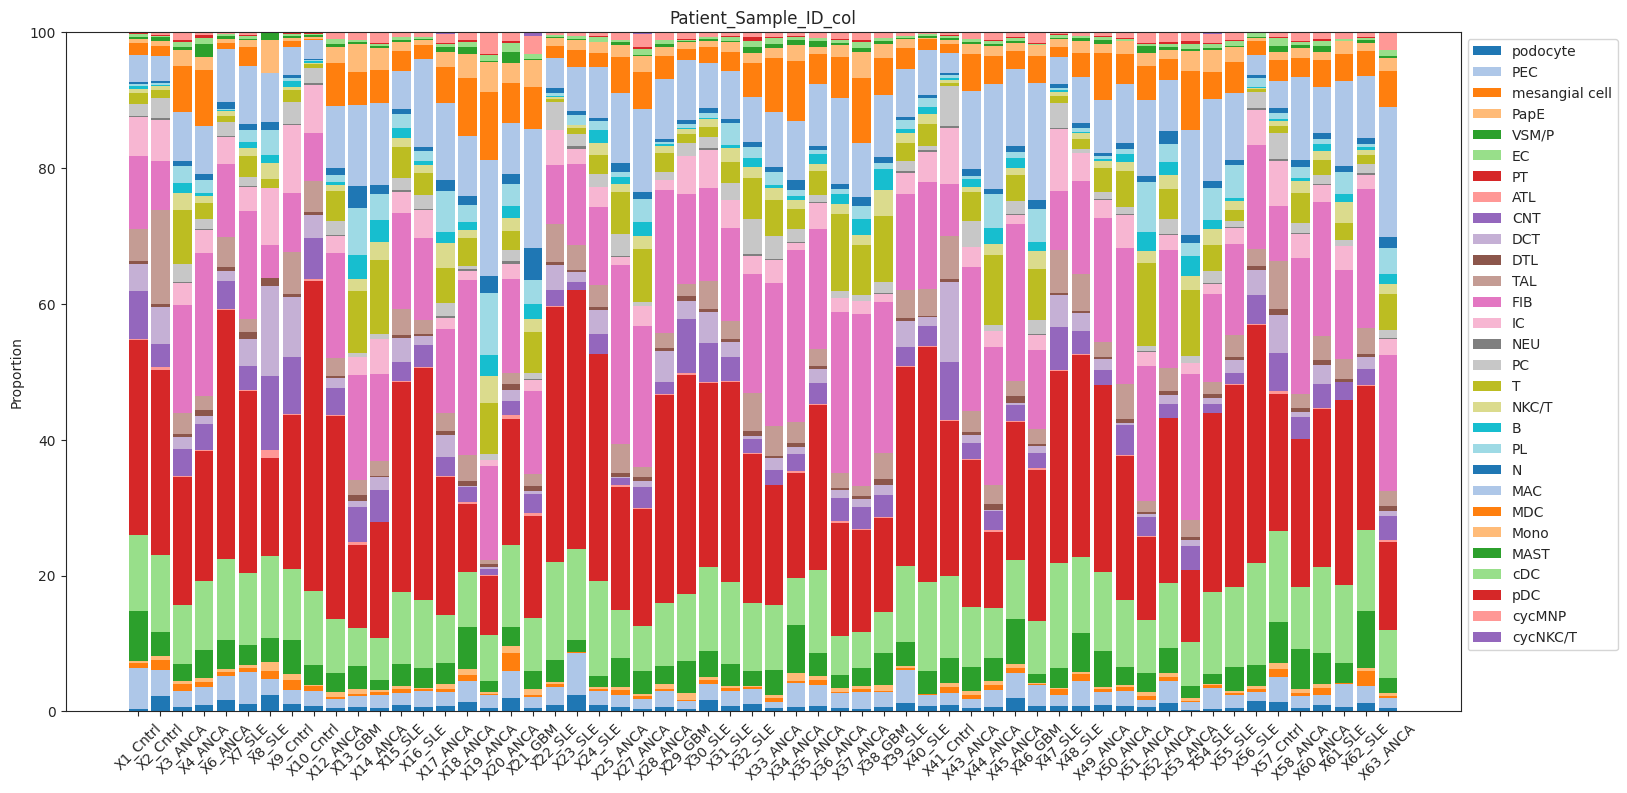

In [18]:
# Stacked barplot for each sample

plt.rcParams['figure.figsize'] = [18, 9]
viz.stacked_barplot(data_Xen, feature_name="Patient_Sample_ID_col")
plt.show()



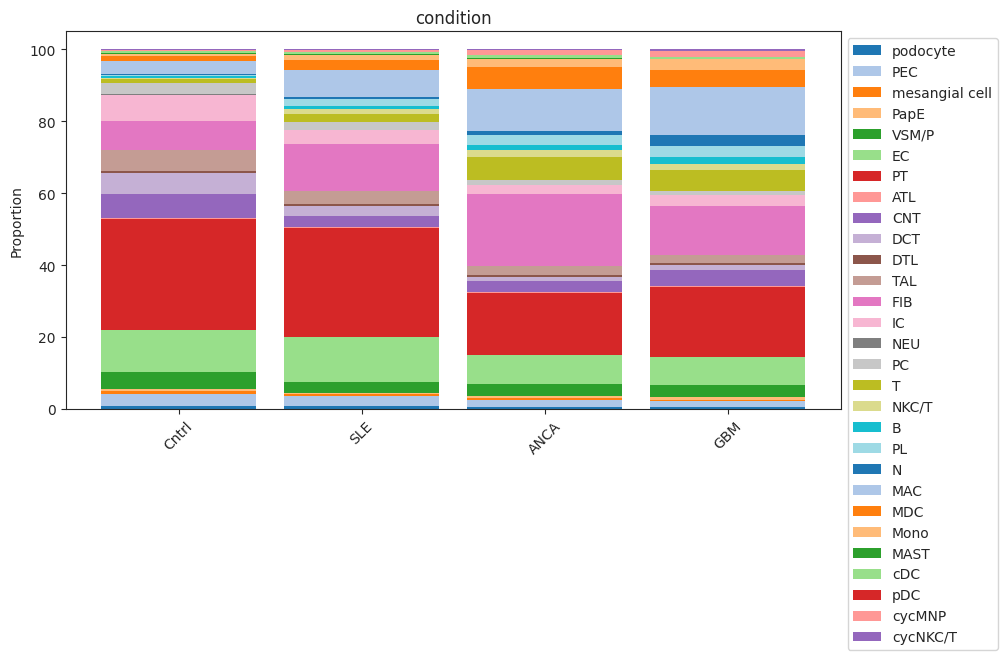

In [19]:
data_Xen.obs["condition"]=data_Xen.obs["Patient_Sample_ID_col"].str.split("_").str[1]

con_order=['Cntrl', 'SLE', 'ANCA', 'GBM']
data_Xen.obs["condition"]=pd.Categorical(data_Xen.obs["condition"], categories=con_order, ordered=True)
    
# Stacked barplot for diff conditoons
plt.rcParams['figure.figsize'] = [10,5]

viz.stacked_barplot(data_Xen, feature_name="condition")
plt.show()

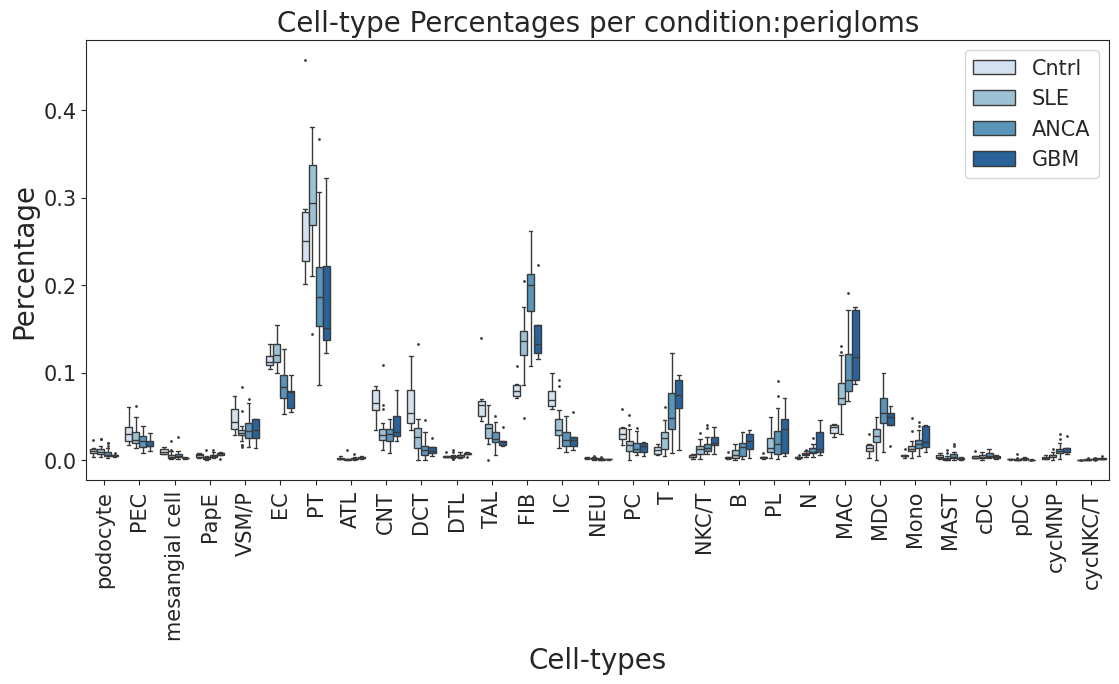

In [20]:
#plt.rcParams["figure.figsize"] = (30, 30)
# Grouped boxplots. No facets, relative abundance, no dots.
ax = viz.boxplots(
    data_Xen,
    feature_name="condition",
    plot_facets=False,
    y_scale="relative",
    add_dots=False,
    figsize=(12,6)
)

# Access the figure
fig = ax.get_figure()

# Customize text elements
ax.set_title("Cell-type Percentages per condition:perigloms", fontsize=20)  # Title size
ax.set_xlabel("Cell-types", fontsize=20)  # X-axis label size
ax.set_ylabel("Percentage", fontsize=20)  # Y-axis label size
ax.legend(fontsize=15)

# Customize tick labels
ax.tick_params(axis='x', labelsize=15)  # X-tick size
ax.tick_params(axis='y', labelsize=15)  # Y-tick size

plt.savefig('Boxplot_CellType_Percentages_periglom_scCODA.png', bbox_inches = 'tight')
#plt.savefig('Boxplot_CellType_Percentages_periglom_scCODA.pdf', bbox_inches = 'tight')

plt.show()



In [21]:
df_sampleXcelltypes["condition"]=df_sampleXcelltypes["Patient_Sample_ID_col"].str.split("_").str[1]

con_order=['Cntrl', 'SLE', 'ANCA', 'GBM']
df_sampleXcelltypes["condition"]=pd.Categorical(df_sampleXcelltypes["condition"], categories=con_order, ordered=True)

In [22]:

# row-wise sum of cell counts 
cell_type_columns = df_sampleXcelltypes.columns.difference(['Patient_Sample_ID_col', 'condition'])
df_sampleXcelltypes['Total_Cells'] = df_sampleXcelltypes[cell_type_columns].sum(axis=1)

# ## Calculate Percentages
for col in cell_type_columns:
    df_sampleXcelltypes[col] = (df_sampleXcelltypes[col] / df_sampleXcelltypes['Total_Cells'])*100

# Melt the df for Seaborn plotting
df_sampleXcelltypes_long = df_sampleXcelltypes.melt(id_vars=['Patient_Sample_ID_col', 'condition'], 
                  value_vars=cell_type_columns, 
                  var_name='Cell_Type', 
                  value_name='Percentage')

df_sampleXcelltypes_long

,Patient_Sample_ID_col,condition,Cell_Type,Percentage
0,X1_Cntrl,Cntrl,ATL,0.109692
1,X2_Cntrl,Cntrl,ATL,0.331911
2,X3_ANCA,ANCA,ATL,0.135161
3,X4_ANCA,ANCA,ATL,0.201613
4,X6_ANCA,ANCA,ATL,0.148221
...,...,...,...,...
1677,X58_ANCA,ANCA,podocyte,0.535519
1678,X60_ANCA,ANCA,podocyte,0.952241
1679,X61_SLE,SLE,podocyte,0.589971
1680,X62_SLE,SLE,podocyte,1.302401


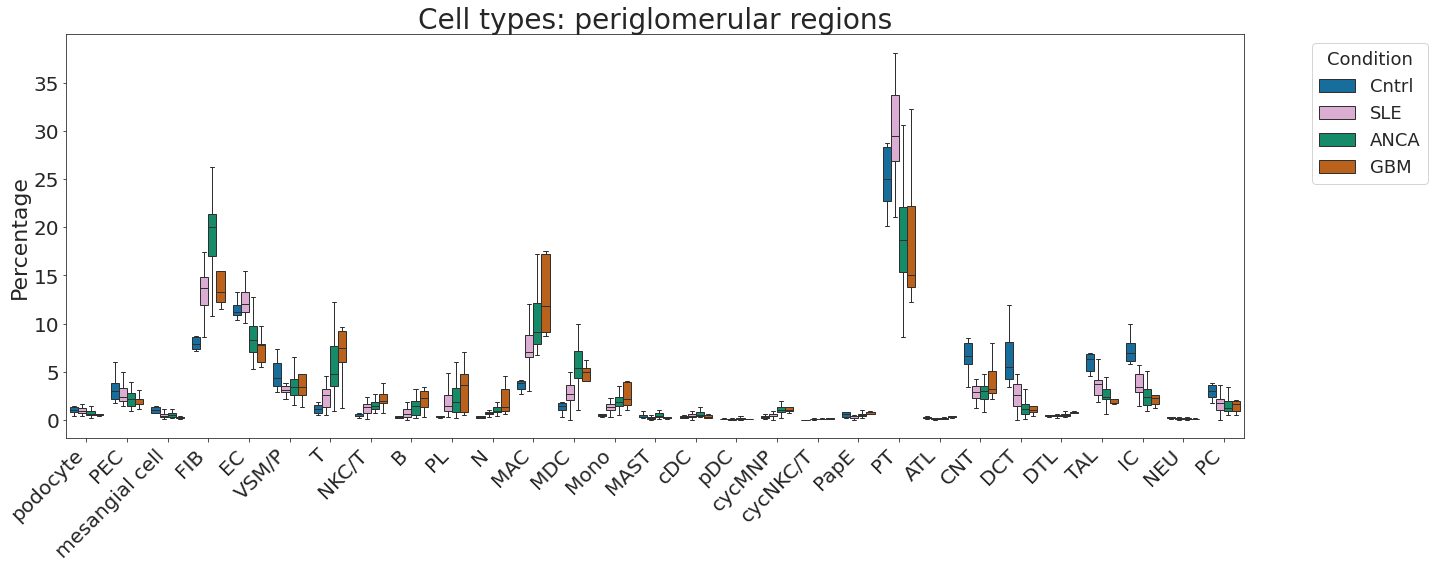

In [23]:

# Define custom colors for each condition
custom_palette = {
    'Cntrl': '#0173b2',  
    'SLE': '#E3A5D6FF',   
    'ANCA': '#029e73',   
    'GBM': '#d55e00'     
}

# Define the specific order of cell types on the x-axis
cell_type_order = [
    'podocyte', 'PEC', 'mesangial cell', 'FIB', 'EC','VSM/P',
    'T', 'NKC/T', 'B', 'PL', 'N', 'MAC', 'MDC', 'Mono', 'MAST', 'cDC', 'pDC', 'cycMNP', 'cycNKC/T', 
    'PapE', 'PT', 'ATL', 'CNT', 'DCT', 'DTL', 'TAL', 'IC', 'NEU', 'PC'
]

# Step 4: Create the boxplot
plt.figure(figsize=(20, 8))
sns.boxplot(
    data=df_sampleXcelltypes_long, 
    x='Cell_Type', 
    y='Percentage', 
    hue='condition', 
    palette=custom_palette, 
    order=cell_type_order,
    showfliers=False  # Suppress outliers
)

# Customize fonts and plot
title_fontsize = 28
label_fontsize = 22
tick_fontsize = 20
legend_fontsize = 18

plt.title('Cell types: periglomerular regions', fontsize=title_fontsize)
plt.xlabel("")  # Remove x-axis label
plt.ylabel('Percentage', fontsize=label_fontsize)
plt.xticks(rotation=45, fontsize=tick_fontsize, ha='right', va='top')
plt.yticks(fontsize=tick_fontsize)
plt.legend(title='Condition', title_fontsize=legend_fontsize, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("Boxplot_CellType_Percentages_periglom.png")
plt.savefig("Boxplot_CellType_Percentages_periglom.pdf")
plt.show()


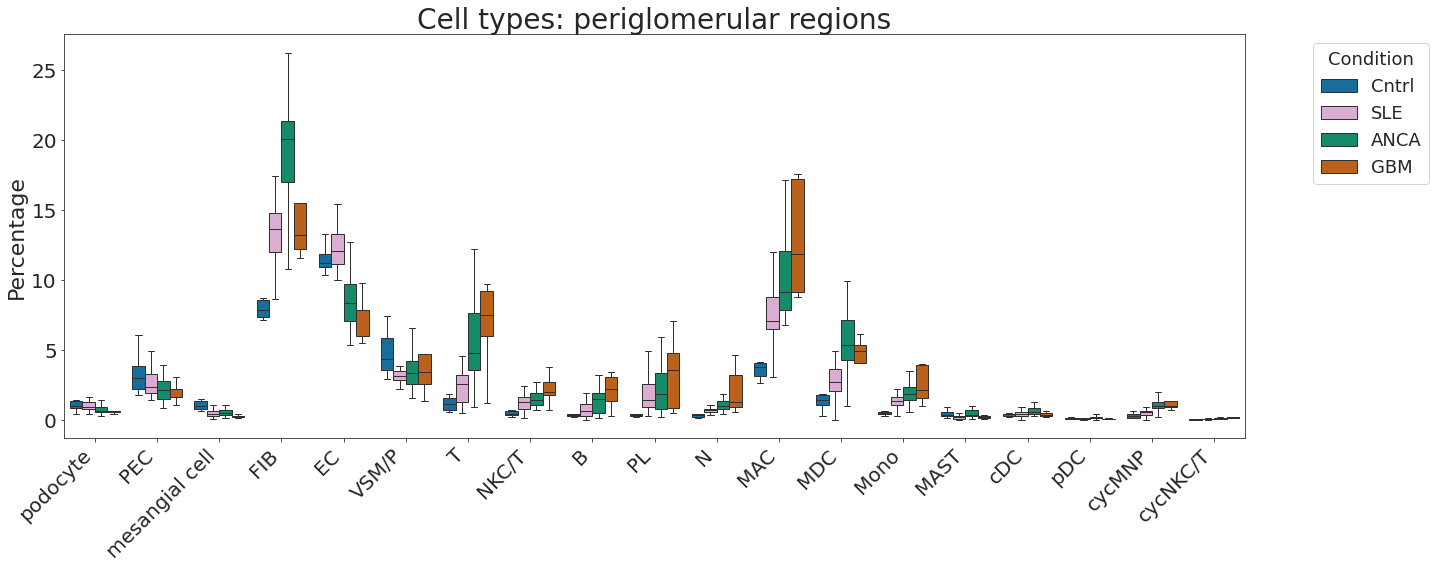

In [24]:


# Define the specific order of cell types on the x-axis
cell_type_order = [
    'podocyte', 'PEC', 'mesangial cell', 'FIB', 'EC','VSM/P',
    'T', 'NKC/T', 'B', 'PL', 'N', 'MAC', 'MDC', 'Mono', 'MAST', 'cDC', 'pDC', 'cycMNP', 'cycNKC/T'
    
    #, 'PapE', 'PT', 'ATL', 'CNT', 'DCT', 'DTL', 'TAL', 'IC', 'NEU', 'PC'
]

# Step 4: Create the boxplot
plt.figure(figsize=(20, 8))
sns.boxplot(
    data=df_sampleXcelltypes_long, 
    x='Cell_Type', 
    y='Percentage', 
    hue='condition', 
    palette=custom_palette, 
    order=cell_type_order,
    showfliers=False  # Suppress outliers
)

# Customize fonts and plot
title_fontsize = 28
label_fontsize = 22
tick_fontsize = 20
legend_fontsize = 18

plt.title('Cell types: periglomerular regions', fontsize=title_fontsize)
plt.xlabel("")  # Remove x-axis label
plt.ylabel('Percentage', fontsize=label_fontsize)
plt.xticks(rotation=45, fontsize=tick_fontsize, ha='right', va='top')
plt.yticks(fontsize=tick_fontsize)
plt.legend(title='Condition', title_fontsize=legend_fontsize, fontsize=legend_fontsize, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.savefig("Boxplot_CellType_Percentages_periglom_NoTubules.png")
plt.savefig("Boxplot_CellType_Percentages_periglom_NoTubules.pdf")
plt.show()


In [25]:
df_sampleXcelltypes_long

,Patient_Sample_ID_col,condition,Cell_Type,Percentage
0,X1_Cntrl,Cntrl,ATL,0.109692
1,X2_Cntrl,Cntrl,ATL,0.331911
2,X3_ANCA,ANCA,ATL,0.135161
3,X4_ANCA,ANCA,ATL,0.201613
4,X6_ANCA,ANCA,ATL,0.148221
...,...,...,...,...
1677,X58_ANCA,ANCA,podocyte,0.535519
1678,X60_ANCA,ANCA,podocyte,0.952241
1679,X61_SLE,SLE,podocyte,0.589971
1680,X62_SLE,SLE,podocyte,1.302401


In [26]:
median_Percentage = df_sampleXcelltypes_long.groupby(['condition', 'Cell_Type'])['Percentage'].median().reset_index()


In [27]:
median_Percentage.to_csv('median_Percentage_celltypes_PERIGLOM.csv')

In [28]:
filtered_df = median_Percentage[median_Percentage['Cell_Type'] == 'MDC']
#filtered_df['perc']=filtered_df.Percentage*100
filtered_df

,condition,Cell_Type,Percentage
10,Cntrl,MDC,1.421393
39,SLE,MDC,2.719437
68,ANCA,MDC,5.376214
97,GBM,MDC,4.927347


In [29]:
df_sampleXcelltypes_long.Cell_Type.unique()

array(['ATL', 'B', 'CNT', 'DCT', 'DTL', 'EC', 'FIB', 'IC', 'MAC', 'MAST',
       'MDC', 'Mono', 'N', 'NEU', 'NKC/T', 'PC', 'PEC', 'PL', 'PT',
       'PapE', 'T', 'TAL', 'VSM/P', 'cDC', 'cycMNP', 'cycNKC/T',
       'mesangial cell', 'pDC', 'podocyte'], dtype=object)